In [394]:
import pandas as pd 
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, FunctionTransformer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score

In [395]:
df_heart = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")

In [396]:
df_heart.head()

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,63,1,3,145,233,0,150,1
1,37,1,2,130,250,1,187,1
2,56,1,1,120,236,1,178,1
3,57,0,0,120,354,1,163,1
4,57,1,0,140,192,1,148,1


All of these predictors seem mildly important in determining a doctor's diagnosis of a heart attack. I will run a first model with all of these variables and adjust what seems necessary based on coefficients.

**Part 1: Fitting Models**

In [397]:
ct = ColumnTransformer(
    [
      ("dummify", 
      OneHotEncoder(sparse_output = False, handle_unknown='ignore', drop="first"),
      make_column_selector(dtype_include=object)),
      ("standardize", 
      StandardScaler(), 
      make_column_selector(dtype_include=np.number))
    ],
    remainder = "drop"
)

**Q1: KNN**

In [398]:
# First model with all variables.

X = df_heart.drop("output", axis=1)
y = df_heart["output"]

pipeline = Pipeline(
  [("selection", ct),
  ("kNN", KNeighborsClassifier())]
).set_output(transform="pandas")

neighbors = {'kNN__n_neighbors': [1, 3, 5, 7, 15]}

gscv = GridSearchCV(pipeline, neighbors, cv=5, scoring="roc_auc")

gscv_fitted = gscv.fit(X, y)

params_df = pd.DataFrame(gscv_fitted.cv_results_["params"])
results_df = params_df.assign(scores=gscv_fitted.cv_results_["mean_test_score"])

In [399]:
# Trying all sorts of different options - the final ouput shown is the best ROC AUC

X = df_heart.drop(["output", "restecg", "chol"], axis=1)
y= df_heart["output"]

pipeline = Pipeline(
  [("selection", ct),
  ("kNN", KNeighborsClassifier())]
).set_output(transform="pandas")

neighbors = {'kNN__n_neighbors': [1, 3, 5, 7, 15]}

gscv = GridSearchCV(pipeline, neighbors, cv=5, scoring="roc_auc")

gscv_fitted = gscv.fit(X, y)

params_df = pd.DataFrame(gscv_fitted.cv_results_["params"])
results_df = params_df.assign(scores=gscv_fitted.cv_results_["mean_test_score"])
results_df.sort_values(by="scores", ascending=False).head(n=1)

,kNN__n_neighbors,scores
4,15,0.853045


The model, using all of the predictors besides resting electrocardiographic results and cholesterol gave a cross-validated ROC AUC score of 0.853.

In [400]:
knn_pipeline = Pipeline(
  [("selection", ct),
  ("kNN", KNeighborsClassifier(n_neighbors=15))]
).set_output(transform="pandas")

knn_fit = knn_pipeline.fit(X, y)

In [401]:
y_prob = cross_val_predict(knn_pipeline, X, y, cv=5, method="predict_proba")[:, 1]

fpr, tpr, thresholds = roc_curve(y, y_prob)
roc_auc = roc_auc_score(y, y_prob)

roc_data = pd.DataFrame({
    "method": "KNN",
    "FPR": fpr,
    "TPR": tpr
})

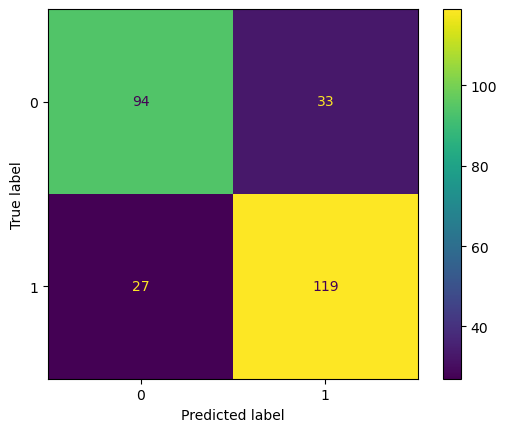

In [402]:
y_pred_knn = cross_val_predict(knn_pipeline, X, y, cv=5)
cm = confusion_matrix(y, y_pred_knn)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y)).plot()

It is not applicable to interpret coefficients with a KNN model.

**Q2: Logistic Regression**

In [403]:
# First model with all variables.

X = df_heart.drop("output", axis=1)
y= df_heart["output"]

pipeline = Pipeline(
  [("selection", ct),
  ("log", LogisticRegression())]
).set_output(transform="pandas")

reg_terms = {"log__C": [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

gscv = GridSearchCV(pipeline, reg_terms, cv=5, scoring="roc_auc")

gscv_fitted = gscv.fit(X, y)

params_df = pd.DataFrame(gscv_fitted.cv_results_["params"])
results_df = params_df.assign(scores=gscv_fitted.cv_results_["mean_test_score"])

In [404]:
# Trying all sorts of different variable combinations. Output shown is the best model.

X = df_heart.drop(["output", "restecg", "age"], axis=1)
y= df_heart["output"]

pipeline = Pipeline(
  [("selection", ct),
  ("log", LogisticRegression())]
).set_output(transform="pandas")

reg_terms = {"log__C": [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

gscv = GridSearchCV(pipeline, reg_terms, cv=5, scoring="roc_auc")

gscv_fitted = gscv.fit(X, y)

params_df = pd.DataFrame(gscv_fitted.cv_results_["params"])
results_df = params_df.assign(scores=gscv_fitted.cv_results_["mean_test_score"])
results_df.sort_values(by="scores", ascending=False).head(n=1)

,log__C,scores
4,10.0,0.859289


The model, using all of the predictors besides resting electrocardiographic results and age, gave a cross-validated ROC AUC score of 0.8593.

In [405]:
y_prob = cross_val_predict(log_pipeline, X, y, cv=5, method="predict_proba")[:, 1]

fpr, tpr, thresholds = roc_curve(y, y_prob)
roc_auc = roc_auc_score(y, y_prob)

temp_data = pd.DataFrame({
    "method": "Logistic Regression",
    "FPR": fpr,
    "TPR": tpr
})

roc_data = pd.concat([roc_data, temp_data], axis=0)

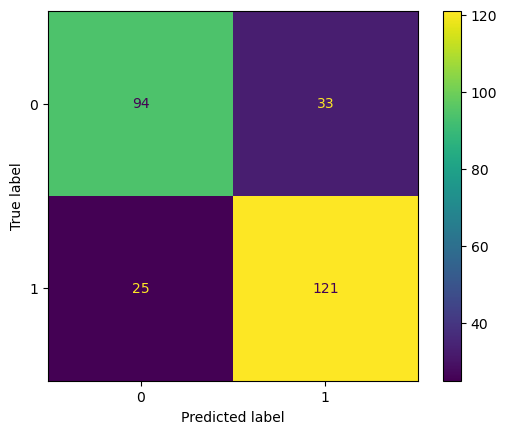

In [406]:
y_pred_log = cross_val_predict(log_pipeline, X, y, cv=5)
cm = confusion_matrix(y, y_pred_log)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y)).plot()

In [407]:
log_pipeline = Pipeline(
  [("selection", ct),
  ("logistic_regression", LogisticRegression(C=10))]
).set_output(transform="pandas")

log_fit = log_pipeline.fit(X, y)

logistic_regression_model = log_pipeline.named_steps["logistic_regression"]

coef = logistic_regression_model.coef_[0]
feature_names = X.columns

coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coef
})

coef_df

,Feature,Coefficient
0,sex,-0.988176
1,cp,0.881753
2,trtbps,-0.483509
3,chol,-0.341750
4,thalach,1.013340


A higher chest pain increases your odds of having a heart attack; same with maximum heart rate achieved during exercise. A higher resting blood pressure decreases your odds of having a heart attack; same with cholesterol. Being a female is associated with less of a risk of heart attack as being male.

**Q3: Decision Tree**

In [408]:
# First model with all variables.

X = df_heart.drop("output", axis=1)
y= df_heart["output"]

pipeline = Pipeline(
  [("selection", ct),
  ("tree", DecisionTreeClassifier())]
).set_output(transform="pandas")

alphas = {"tree__ccp_alpha": [0.001, 0.01, 0.1, 0.2, 0.5, 1, 5, 10]}

gscv = GridSearchCV(pipeline, alphas, cv=5, scoring="roc_auc")

gscv_fitted = gscv.fit(X, y)

params_df = pd.DataFrame(gscv_fitted.cv_results_["params"])
results_df = params_df.assign(scores=gscv_fitted.cv_results_["mean_test_score"])

In [409]:
# Trying all sorts of different variable combinations. Output shown is the best model.

X = df_heart.drop(["output", "thalach"], axis=1)
y= df_heart["output"]

pipeline = Pipeline(
  [("selection", ct),
  ("tree", DecisionTreeClassifier())]
).set_output(transform="pandas")

alphas = {"tree__ccp_alpha": [0.001, 0.01, 0.1, 0.2, 0.5, 1, 5, 10]}

gscv = GridSearchCV(pipeline, alphas, cv=5, scoring="roc_auc")

gscv_fitted = gscv.fit(X, y)

params_df = pd.DataFrame(gscv_fitted.cv_results_["params"])
results_df = params_df.assign(scores=gscv_fitted.cv_results_["mean_test_score"])
results_df.sort_values(by="scores", ascending=False).head(n=1)

,tree__ccp_alpha,scores
1,0.01,0.783892


The model, using all of the predictors besides maximum heart rate during exercise, gave a cross-validated ROC AUC score of 0.784.

In [410]:
tree_pipeline = Pipeline(
  [("selection", ct),
  ("tree", DecisionTreeClassifier(ccp_alpha=0.01))]
).set_output(transform="pandas")

tree_fit = tree_pipeline.fit(X, y)

In [411]:
y_prob = cross_val_predict(tree_pipeline, X, y, cv=5, method="predict_proba")[:, 1]

fpr, tpr, thresholds = roc_curve(y, y_prob)
roc_auc = roc_auc_score(y, y_prob)

temp_data = pd.DataFrame({
    "method": "Decision Tree",
    "FPR": fpr,
    "TPR": tpr
})

roc_data = pd.concat([roc_data, temp_data], axis=0)

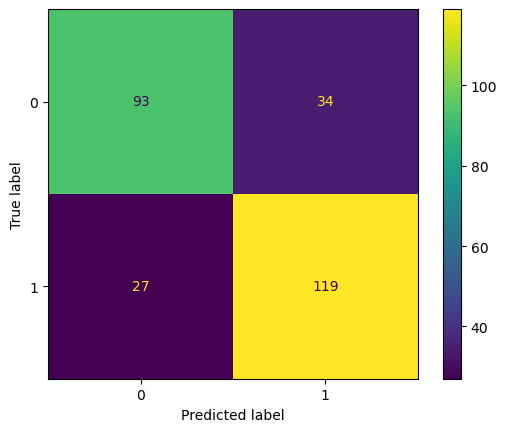

In [412]:
y_pred_tree = cross_val_predict(tree_pipeline, X, y, cv=5)
cm = confusion_matrix(y, y_pred_tree)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y)).plot()

**Q4: Interpretations**

In my observations, the most important variables were the predictors that were always adding value to the different models I tested (each with varying feature sets not shown in the rendered document).

Sex, chest pain type and resting blood pressure were the three most important variables by that qualitative measure. Based on the choice of model, where KNN, Decision Tree, etc., one of the other predictor variables in the dataset worsened the cross-validated ROC AUC score.

**Q5: ROC Curve**

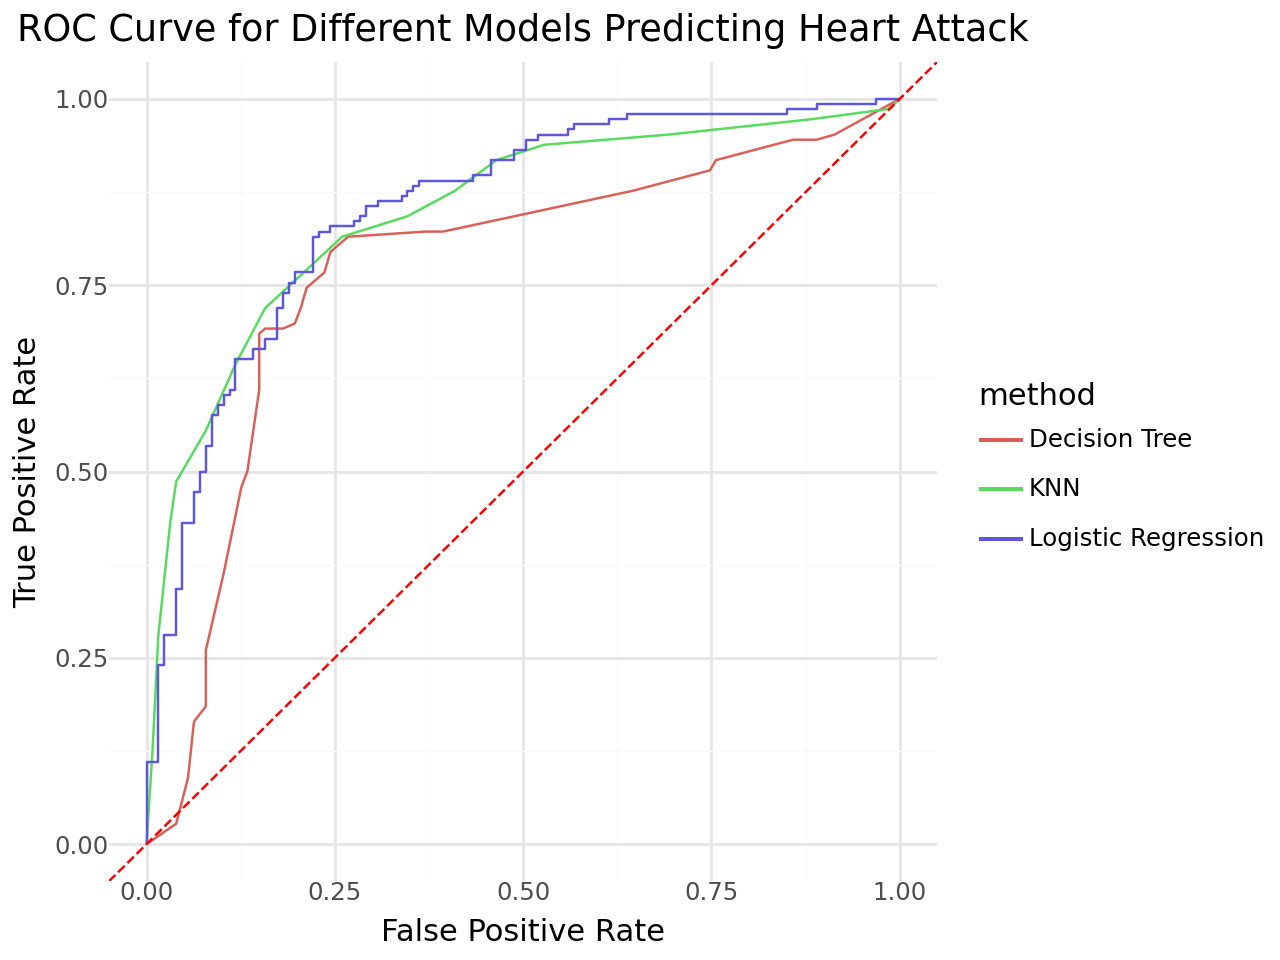

In [413]:
from plotnine import ggplot, aes, geom_line, labs, theme_minimal, geom_abline

(ggplot(roc_data, aes(x="FPR", y="TPR", color="method")) +
geom_line() +
geom_abline(slope=1, intercept=0, linetype='--', color="red") +
labs(title="ROC Curve for Different Models Predicting Heart Attack",
         x="False Positive Rate",
         y="True Positive Rate") +
theme_minimal())

**Part Two: Metrics**

In [414]:
# Specificity = True Negatives / (True Negatives + False Positives)

from sklearn.metrics import make_scorer

def specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

specificity_scorer = make_scorer(specificity)

In [415]:
X = df_heart.drop(["output", "restecg", "chol"], axis=1)
y= df_heart["output"]

recall_knn = cross_val_score(knn_pipeline, X, y, cv=5, scoring='recall').mean()

precision_knn = cross_val_score(knn_pipeline, X, y, cv=5, scoring='precision').mean()

specificity_knn = cross_val_score(knn_pipeline, X, y, cv=5, scoring=specificity_scorer).mean()

recall_knn, precision_knn, specificity_knn

(0.8158620689655173, 0.7833704115684095, 0.74)

In [416]:
X = df_heart.drop(["output", "restecg", "age"], axis=1)
y= df_heart["output"]

recall_log = cross_val_score(log_pipeline, X, y, cv=5, scoring='recall').mean()

precision_log = cross_val_score(log_pipeline, X, y, cv=5, scoring='precision').mean()

specificity_log = cross_val_score(log_pipeline, X, y, cv=5, scoring=specificity_scorer).mean()

recall_log, precision_log, specificity_log

(0.8289655172413793, 0.7901181614084839, 0.7387692307692308)

In [417]:
X = df_heart.drop(["output", "thalach"], axis=1)
y= df_heart["output"]

recall_tree = cross_val_score(tree_pipeline, X, y, cv=5, scoring='recall').mean()

precision_tree = cross_val_score(tree_pipeline, X, y, cv=5, scoring='precision').mean()

specificity_tree = cross_val_score(tree_pipeline, X, y, cv=5, scoring=specificity_scorer).mean()

recall_tree, precision_tree, specificity_tree

(0.8156321839080458, 0.7852347101850145, 0.730153846153846)

**Part Three: Discussion**

**Q1**
The hospital faces severe lawsuits if they deem a patient to be low risk, and that patient later experiences a heart attack.

With this situation, it is very important that the model correctly identifies patients who are truly at risk (true positives). A high recall is the metric to focus on. I would recommend the Logistic Regression to the hopsital, as they should expect a recall score of 0.816 in the future with this method: higher than the other two methods.

**Q2**
The hospital is overfull, and wants to only use bed space for patients most in need of monitoring due to heart attack risk.

With this situation, it is very important that the model correctly identifies patients who are not truly at risk (True Negatives). Specificity is the metric to focus on. Precision is important as well because we want to lower the amount of false positives - patients who are not in need of care. All of the models have very similar results - I would focus on the one with the highest specificity - the KNN model.

**Q3**
The hospital is studying root causes of heart attacks, and would like to understand which biological measures are associated with heart attack risk.

In this case, there isn't a strict metric to use. Instead, you need to view the coefficients of a model and determine by their sign and magnitude their individual contributions to heart attacks. With the three models we have used in this lab, Logistic Regression is the only one that uses coefficients in its modeling.

**Q4**
The hospital is training a new batch of doctors, and they would like to compare the diagnoses of these doctors to the predictions given by the algorithm to measure the ability of new doctors to diagnose patients.

In this case, it is very open ended on what metric the hosiptal should use. Overall accuracy makes the most sense. Of the metrics we tested above, I would recommend recall. In the case of heart attacks, it is very important that doctors correctly identify the cases of concern and recall does that. I would use the logistic regression model for this.

**Part Four: Validation**

In [418]:
ha_validation = pd.read_csv("https://www.dropbox.com/s/jkwqdiyx6o6oad0/heart_attack_validation.csv?dl=1")

In [419]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score

# For KNN

X = df_heart.drop(["output", "restecg", "chol"], axis=1)
y= df_heart["output"]

knn_pipeline = Pipeline(
  [("selection", ct),
  ("kNN", KNeighborsClassifier(n_neighbors=15))]
).set_output(transform="pandas")

knn_fit = knn_pipeline.fit(X, y)


X_test = ha_validation.drop(["output", "restecg", "chol"], axis=1)
y_test = ha_validation["output"]

knn_pred = knn_fit.predict(X_test)

roc_auc = roc_auc_score(y_test, knn_fit.predict_proba(X_test)[:, 1])
precision = precision_score(y_test, knn_pred)
recall = recall_score(y_test, knn_pred)

roc_auc, precision, recall

(0.8875598086124402, 0.9333333333333333, 0.7368421052631579)

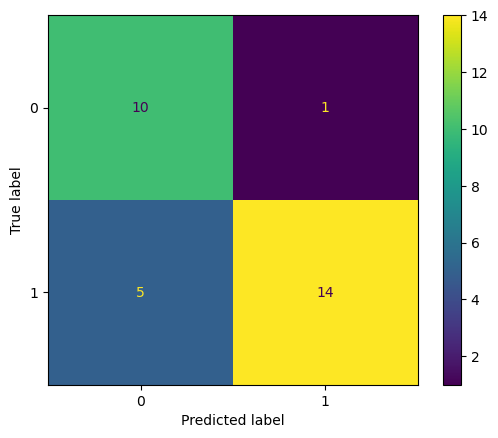

In [420]:
cm = confusion_matrix(y_test, knn_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y)).plot()

In [421]:
# For Logistic

X = df_heart.drop(["output", "restecg", "age"], axis=1)
y= df_heart["output"]

log_pipeline = Pipeline(
  [("selection", ct),
  ("logistic_regression", LogisticRegression(C=10))]
).set_output(transform="pandas")

log_fit = log_pipeline.fit(X, y)


X_test = ha_validation.drop(["output", "restecg", "age"], axis=1)
y_test = ha_validation["output"]

log_pred = log_fit.predict(X_test)

roc_auc = roc_auc_score(y_test, log_fit.predict_proba(X_test)[:, 1])
precision = precision_score(y_test, log_pred)
recall = recall_score(y_test, log_pred)

roc_auc, precision, recall

(0.8947368421052632, 0.8235294117647058, 0.7368421052631579)

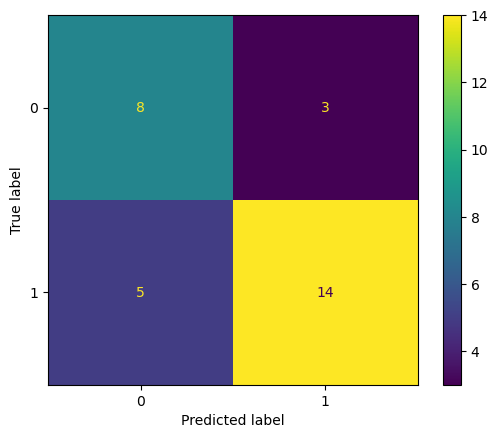

In [422]:
cm = confusion_matrix(y_test, log_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y)).plot()

In [423]:
# For Decision

X = df_heart.drop(["output", "thalach"], axis=1)
y= df_heart["output"]

tree_pipeline = Pipeline(
  [("selection", ct),
  ("tree", DecisionTreeClassifier(ccp_alpha=0.01))]
).set_output(transform="pandas")

tree_fit = tree_pipeline.fit(X, y)


X_test = ha_validation.drop(["output", "thalach"], axis=1)
y_test = ha_validation["output"]

tree_pred = tree_fit.predict(X_test)

roc_auc = roc_auc_score(y_test, tree_fit.predict_proba(X_test)[:, 1])
precision = precision_score(y_test, tree_pred)
recall = recall_score(y_test, tree_pred)

roc_auc, precision, recall

(0.8373205741626792, 0.9333333333333333, 0.7368421052631579)

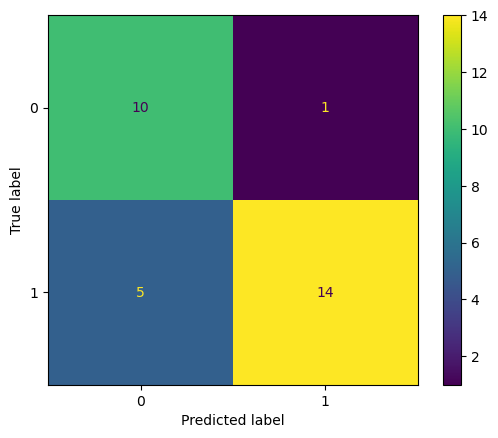

In [424]:
cm = confusion_matrix(y_test, tree_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y)).plot()

We are very precise across the board, especially with the KNN and Decision Tree models. Our measures of success seem approximately very similar between our training data and our validation data.

**Part Five: Cohen’s Kappa**

In [433]:
from sklearn.metrics import cohen_kappa_score

knn_cks = cohen_kappa_score(y_test, knn_pred)
log_cks = cohen_kappa_score(y_test, log_pred)
tree_cks = cohen_kappa_score(y_test, tree_pred)

knn_cks, log_cks, tree_cks

(0.6, 0.4470046082949308, 0.6)

In this case, interestingly enough, the KNN and Decision Tree models have the same Cohen Kappa Score with the validation set. My conclusions from above do slightly change with these results. Now, I would feel less confident using the Logistic Regression Model, as it has a definitive lower score than the other two models with the validation set. 

I would follow this up with cross-validated predictions on the entire data set with a Cohen Kappa Score for each model before coming to a final conclusion though.